Here we aim at performing inference of 1 Gaussian latent variable parameterizing N Bernoulli observations.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.stats import gaussian_kde

from edward.models import Normal, Bernoulli

plt.style.use('ggplot')

In [2]:
ed.set_seed(42)

In [ ]:
lams = [.1, 1., 10]

xs = np.linspace(0, 5, 500)
ys = [np.exp(-l * xs**2) for l in lams]
for i in range(len(lams)): plt.plot(xs, ys[i], label=str(lams[i]))
plt.legend()
plt.xlabel('x')
plt.ylabel('$p_0$')
plt.title('$\exp(-\lambda x^2)$ for different $\lambda$s')
plt.show()

In [3]:
# Model
N = 100

x = Normal(1., .5)
h = Bernoulli(probs=tf.exp(-x**2), sample_shape=N)

In [4]:
# Data
sess = ed.get_session()
h_data, x_data = sess.run([h, x])

In [12]:
x_data

0.8419608

In [13]:
h_data

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0], dtype=int32)

In [6]:
# Inference
qx = Normal(tf.Variable(0.), tf.nn.softplus(tf.Variable(1.0))) # Initialization must be at a nonzero probability point!

inference = ed.KLqp({x: qx}, data={h: h_data})
inference.initialize()

tf.global_variables_initializer().run()

loss = np.empty(inference.n_iter)
for i in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)
    loss[i] = info_dict["loss"]

inference.finalize()

/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/edward/util/random_variables.py:50: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/home/pedro/IST/Thesis/edward-venv/lib/python3.5/site-packages/edward/util/random_variables.py:51: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 10s | Loss: 70.408


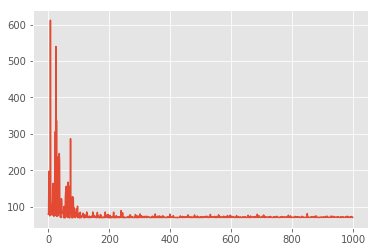

In [7]:
plt.plot(loss)
plt.show()

In [8]:
qx.sample()

<tf.Tensor 'Normal_1/sample_1/Reshape:0' shape=() dtype=float32>

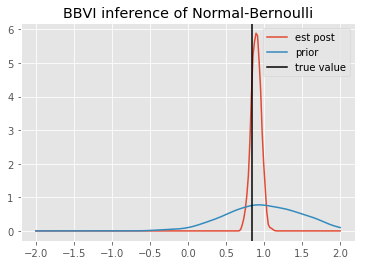

In [9]:
n_samples = 1000

samples_post = qx.sample(n_samples).eval()
samples_prior = x.sample(n_samples).eval()

posterior_density = gaussian_kde(samples_post)
prior_density = gaussian_kde(samples_prior)

xs = np.linspace(-2,2,200)
plt.plot(xs, posterior_density(xs), label='est post')
plt.plot(xs, prior_density(xs), label='prior')
plt.axvline(x=x_data, c='black', label='true value')
plt.legend()
plt.title('BBVI inference of Normal-Bernoulli')
plt.show()

In [10]:
qx.loc.eval()

0.894569

In [11]:
qx.scale.eval()

0.06546943